In [1]:
#!/usr/bin/python
import sys
import pickle
import os
sys.path.append("../tools/")

In [2]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

C:\Users\Fernando\Miniconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
%matplotlib inline

# Funções definidas
Funções foram criadas ao longo do código para facilitar a manipulação dos dados. Todas as funções no início do código.

In [4]:
def F_RetirarNaNs(data_dict):
    '''
    Retira os NaNs 
    data_dict: dicionário com diversas features para cada pessoa
    return: dicionário de entrada, exceto as features que possuem valor NaN
    '''
    
    for k1, v1 in data_dict.iteritems():
        data_dict[k1] = {key:value for key, value in v1.iteritems() if value != 'NaN'}
    
    return data_dict

In [5]:
def F_FeatureScalling(data_dict, not_scale, features):
    '''
    Cria nova escala para features de cada pessoa no dicionário de entrada
    data_dict: dicionário com diversas features para cada pessoa
    not_scale: features que não devem ser alteradas
    return: tuple com features do dicionário em nova escala e um dicionário com o conversor de escalas
    '''
    
    from sklearn.preprocessing import MinMaxScaler
    
    #Criar escala para cada feature
    scale_feature = dict()
    for feature in features: 
        if not feature in not_scale:
            scale_feature[feature] = MinMaxScaler()
            scale_feature[feature].fit_transform(np.array([data_dict[key][feature]
                                                for key in data_dict.keys()
                                                if feature in data_dict[key].keys()]).reshape(-1,1))
    
    #Aplicar escala sobre os campos de interesse
    for k1, v1 in data_dict.iteritems():
        for key, value in v1.iteritems():
            if key in features and not key in not_scale:
                data_dict[k1][key] = scale_feature[key].transform(np.array(value).reshape(-1,1))[0][0]
            else:
                data_dict[k1][key] = value
    
    return data_dict, scale_feature

In [6]:
def F_OrdemFeatures(data_dict, features):
    '''
    Retorna uma lista com as features ordenadas por valor
    data_dict: dicionários com as features
    features: features a serem ordenadas
    return: lista com ordem das features
    '''
    
    ordem = {}
    
    for feature in features:
        
        aux = {keys: values[feature] for keys, values in data_dict.items() if feature in values.keys()}
        
        ordem[feature] = sorted(aux.keys(), key=lambda x:data_dict[x][feature])
        
    return ordem

In [7]:
def F_PlotOutliers(test_list, ordem):
    '''
    Criar gráfico com valores ordenados
    test_list: lista com os dados
    ordem: ordem de plotagem 
    return: maiores valores em cada gráfico (análise de outliers)
    '''
    
    outliers_dict = {}
    n_dados = len(test_list)
    
    f, gp = plt.subplots(n_dados,1, sharex= True)

    f.set_figheight((2.5*n_dados)//2+1)
    f.set_figwidth(15)

    for jj, feature in enumerate(test_list):
        max_value = 0
        person = ''
        
        try:

            for ii, point in enumerate(ordem[feature]):
                if feature in data_dict[point]:

                    salary = data_dict[point][feature]

                    if max_value < salary:
                        max_value = salary
                        person = point

                    #Registrando os valores extremos encontrados
                    outliers_dict[feature] = [max_value, person]

                    gp[jj].scatter(ii, salary)

                gp[jj].set_title(feature)
        except:
            pass

    plt.show()
    
    return outliers_dict

In [8]:
def F_PessoaEmail(dir_, address):
    
    '''
    Procura no repositório dir_ o endereço de destino contido no email
    dir_: diretório dos emails
    address: email procurado
    '''
    lista = []
    if email in address.keys():
        with open('{}/{}'.format(dir_, address[email], 'r')) as fl:
            lista = [line.split('/')[2] for line in fl]
    
    return lista

In [9]:
def F_ExtraiPoisAbreviados(data_dict):
    '''
    Extrair os POis e abrevia os nomes pela regra de sobrenome-Nome(primeira letra), exemplo, Kenneth Lee Lay para lay-k
    data_dict: dicionário com dados das pessoas
    return: dictionary com nomes convertidos por pessoa
    '''

    aux_list = {}
    for ii in [key for key, value in data_dict.items() if value['poi']==True]:
        string = ii.split(' ')
        name = string[0]

        second_name = string[1][0] if len(string) in [3,2] else string[2][0]
        
        try:
            aux_list[data_dict[ii]['email_address']] = '-'.join([name, second_name]).lower()
        except:
            print 'Erro na chave {key}'.format(key=ii)
        
    return aux_list

In [10]:
def F_StatMsg(email, aux_list):
    '''
    Retorna a quantidade de e-mails trocados com POis
    email: dictionary com os destinos dos emails enviados por uma pessoa
    return: dictionary com contagem do total de emails enviados para POis para cada indivíduo
    '''
    
    count, ratio = {}, {}
    for key in email.keys():
        
        aux = aux_list.copy()
        if key in aux.keys():
        #Não contar a própria pessoa -- acontece quando a pessoa é um poi
            aux.pop(key)
        
        #Somente os que são poi
        lista = [ii for ii in email[key] if ii in aux.values()]
        
        #total de poi com troca de mensagens
        count[key] = len(set(lista))
        
        #razao entre mensagens com poi e total de mensagens
        if len(email[key])>0:
            ratio[key] = len(lista)/float(len(email[key]))
        else:
            ratio[key]= 0
    
    return count, ratio

In [11]:
def F_VerificarExisteFeature():
    '''Verificar se existe chave sem alguma característica 
        return: key e feature faltante, além da quantidade de keys que precisam ser corrigidas
    '''
    
    person_feature = defaultdict(list)
    
    all_features = {key for key, value in my_dataset.items() if all(ii == features_list for ii in value.keys())}
    all_persons = {key for key in my_dataset.keys()}
    
    #procura as pessoas que não tem todas as features e encontra a features faltante
    for jj in all_persons - all_features:
        for ii in features_list:
            if not ii in my_dataset[jj].keys():
                person_feature[jj].append(ii)
    
    print 'Quantidade de pessoas com falta de informações, ', len(person_feature)
    return person_feature

As features selecionadas tem relação com ganhos financeiros e gastos. Novas features serão adicionadas para criar relações de network entre as pessoas no dataset, através dos e-mails.

In [12]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','total_payments', 'bonus', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'restricted_stock','shared_receipt_with_poi','ratio_to','ratio_from'] 

In [13]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Familiarização com os dados

Análise sobre as características da base de dados.

#### Quantidades de POIs e Non-POIs

In [14]:
pois = set( key for key, value in data_dict.items() if value['poi'] == True)
non_pois = set( key for key, value in data_dict.items() if value['poi'] == False)

print 'Quantidade de data points ' + str(len(pois | non_pois))
print 'Quatidade de pois ' + str(len(pois))
print 'Quantidade de non-pois ' + str(len(non_pois))

Quantidade de data points 146
Quatidade de pois 18
Quantidade de non-pois 128


#### Features no data point - quantidade e tipo 

Nosso data set inicial contém 3 tipos de dados:
* Financeiro (em dólares - numérico)
> * salary 
> * deferral_payments 
> * total_payments 
> * loan_advances 
> * bonus 
> * restricted_stock_deferred 
> * deferred_income 
> * total_stock_value 
> * expenses 
> * exercised_stock_options 
> * other 
> * long_term_incentive 
> * restricted_stock
> * director_fees
* e-mail (text string)
> * to_messages
> * email_address
> * from_poi_to_this_person
> * from_messages
> * from_this_person_to_poi
> * shared_receipt_with_poi
* POI 
> * Booleano - True/False se a pessoa é um poi (person of interest)

#### Aplicação de Machine Learning
A partir do data point temos uma relação de features e um target (feature POI).

Nosso objetivo é identificar os POis e Non-Pois no data set, ou seja, precisamos classificar cada pessoa no data set. Para realizar esses trabalho temos como ferramenta os vários algoritmos de machine learning que através de uma base de treino contendo features e targets conseguem aprender a classificar de forma generalizada (necessário controlar overfitting) se uma pessoa é um POI através de suas features (as mesmas contidas no treinamento).

Para generalizar o classificador precisamos escolher quais features trazem informações para melhorar a assertividade do classificador das que criam ruídos e consequentemente pioram dos resultados de métricas de desempenho como acurácia, precisão e recall.

#### Valores NaN

In [15]:
from collections import Counter
counter = Counter()
for key, value in data_dict.items():
    for key_value, value_value in value.items():
        if value_value == 'NaN':
            counter[key_value] += 1

In [16]:
counter

Counter({'bonus': 64,
         'deferral_payments': 107,
         'deferred_income': 97,
         'director_fees': 129,
         'email_address': 35,
         'exercised_stock_options': 44,
         'expenses': 51,
         'from_messages': 60,
         'from_poi_to_this_person': 60,
         'from_this_person_to_poi': 60,
         'loan_advances': 142,
         'long_term_incentive': 80,
         'other': 53,
         'restricted_stock': 36,
         'restricted_stock_deferred': 128,
         'salary': 51,
         'shared_receipt_with_poi': 60,
         'to_messages': 60,
         'total_payments': 21,
         'total_stock_value': 20})

In [17]:
y = [i for _, i in counter.most_common()]
x = [i for i, _ in counter.most_common()]

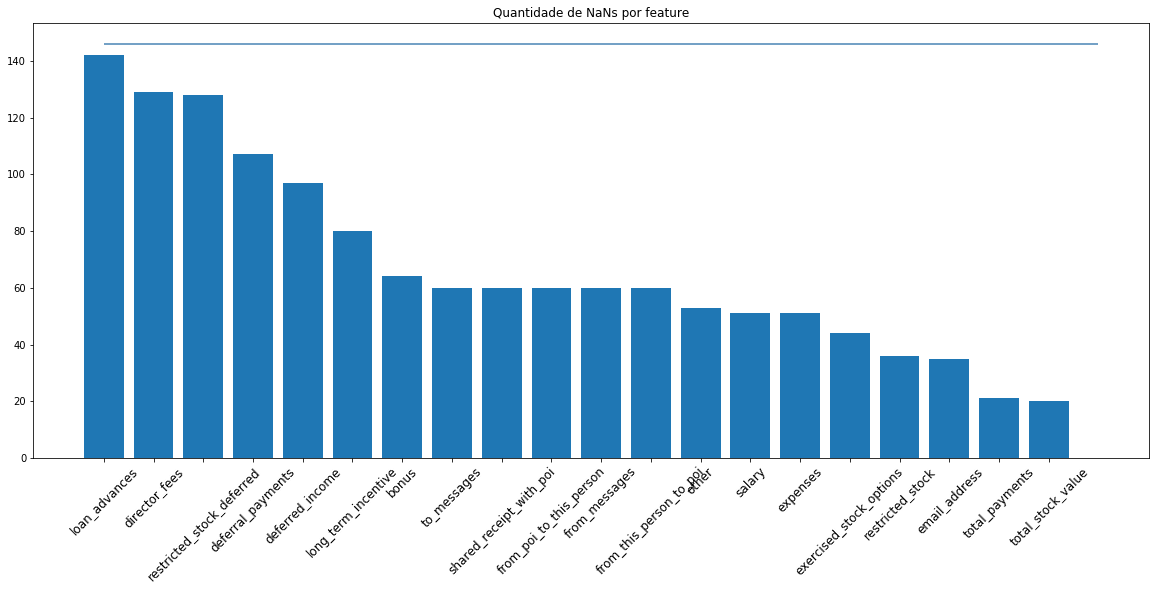

In [18]:
plt.figure(figsize=(20,8))
plt.hlines(y=146, xmin=0, xmax=20, colors='steelblue')
plt.bar(range(len(y)), y)
plt.xticks(range(len(y)),x, rotation = 45, fontsize = 12)
plt.title('Quantidade de NaNs por feature')
plt.show()

Vemos pelo gráfico temos que algumas características possuem muitos valores NaN. Esses valores serão tratados nos passos seguintes e serão analisados os casos em faz sentido substituit NaN por algum valor como 0.

Como nossa base de dados é pequena, excluir dados pode inviabilizar o classificador, pois este não estaria apto a generalizar o resultado, a partir, do treinamento com small data.

# Cleaning Data
Temos que alguns campos estão como 'NaN', logo estes campos não serão considerados neste momento para facilitar a análise de outliers (análise gráfica) e outras análises que a falta de dados pode enviesar. Se os campos com 'NaN' estiverem na feature_list eles serão futuramente adicionados com valor 0.

Antes de retirar os valores NaN

In [19]:
data_dict['METTS MARK']

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [20]:
data_dict = F_RetirarNaNs(data_dict)

Após ser retirado os NaNs

In [21]:
data_dict['METTS MARK']

{'bonus': 600000,
 'email_address': 'mark.metts@enron.com',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

A pasta email_by_address será utilizada nesse trabalho. Como algumas keys em data_dict não possuem e-mail, essas pessoas serão desconsideradas. Isso reduz a base de dados, mas trará maior consistência do que supor que essas não trocam e-mails.

In [22]:
for key in data_dict.keys():
    if not 'email_address' in data_dict[key].keys():
        data_dict.pop(key)

# Task 2: Remove outliers
A análise gráfica será utilizada para descobrir se existem outliers na base de dados.

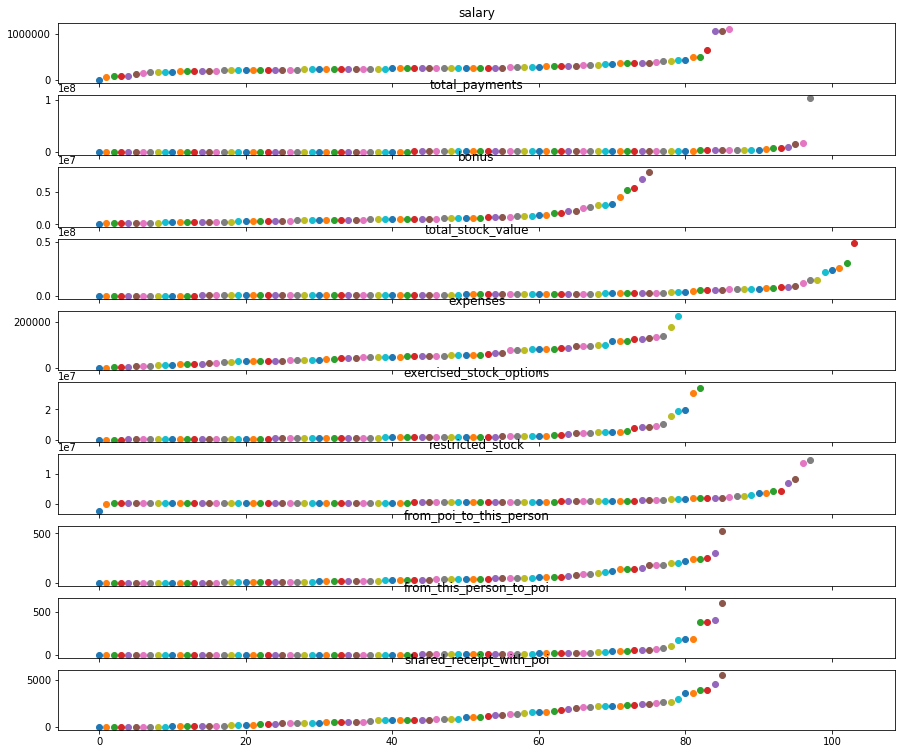

{'bonus': [8000000, 'LAVORATO JOHN J'],
 'exercised_stock_options': [34348384, 'LAY KENNETH L'],
 'expenses': [228763, 'MCCLELLAN GEORGE'],
 'from_poi_to_this_person': [528, 'LAVORATO JOHN J'],
 'from_this_person_to_poi': [609, 'DELAINEY DAVID W'],
 'restricted_stock': [14761694, 'LAY KENNETH L'],
 'salary': [1111258, 'SKILLING JEFFREY K'],
 'shared_receipt_with_poi': [5521, 'BELDEN TIMOTHY N'],
 'total_payments': [103559793, 'LAY KENNETH L'],
 'total_stock_value': [49110078, 'LAY KENNETH L']}

In [23]:
plot_list = ['salary','total_payments', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 
             'restricted_stock', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']
ordem = F_OrdemFeatures(data_dict, plot_list)
F_PlotOutliers(plot_list, ordem)

Temos que os valores extremos nos gráficos estão associadas a pessoas com altos cargos na Enron, como:

**LAVORATO JOHN J**: Principais executivos

**LAY KENNETH L**: fundador e CEO da companhia na época do escândalo

**SKILLING JEFFREY K**: fundador e ex-CEO da companhia na época do escândalo

Essas pessoas são chefes da companhia, assim possuem salários e bonificações diferenciadas dos demais funcionários e seus dados não podem ser considerados outliers.

*É necessário analisar os outros pontos que podem ser outleirs para determinar se também se tratam de pessoas com altos cargos.*

### SALARY

In [24]:
ordem['salary'][-3:]

['FREVERT MARK A', 'LAY KENNETH L', 'SKILLING JEFFREY K']

Os pontos que poderiam ser outliers são de chefes da companhia. Nesse caso temos que além de **LAY KENNETH L** e **SKILLING JEFFREY K** temos **FREVERT MARK A** que era na época CEO de uma subsidiára do grupo a _Enron Whosale Services_

### EXERCISED STOCK OPTIONS

In [25]:
ordem['exercised_stock_options'][-2:]

['HIRKO JOSEPH', 'LAY KENNETH L']

Para exercised_stock_options temos dois altos executivos o que justifica os outliers.

### RESTRICTED STOCK

In [26]:
ordem['restricted_stock'][-3:]

['PAI LOU L', 'WHITE JR THOMAS E', 'LAY KENNETH L']

No caso de restricted stock temos pessoas com altos cargos que recebiam remuneração através de ações associadas a desempenho. 

Temos que as 3 pessoas são altos executivos o que justifica os altos ganhos.

### EMAILS

A quantidade de emails pode variar muito independente da pessoa e cargo devido as funções exercidas, por isso não será considerada um outlier os valores extremos no gráfico.

Após o cleaning data não existem outliers. O que temos é uma discrepância que pode ser considerada normal dentro de renda de uma companhia.

# Task 3 --  Create New Features

As maioria das features estão relacionadas a finanças, mas como vimos na análise de outliers, os rendimentos podem variar muito dentro de uma companhia. Uma forma de deixar a análise de POis mais robusta e trazer para o dataset as relações entre pessoas e POis.

Para trazer a relação entre pessoas no dataset as features relacionadas a envio de e-mails nos auxiliam nesse sentido, mas podemos complementar com a base de dados email_by_address de onde podemos tirar com quantos POis uma pessoa se relacionou enviando ou recebendo e-mails.

Essa cria uma nova feature, mas como não temos o e-mail de todas as pessoas no dataset optei por excluir as pessoas sem e-mail, ou seja, aquelas que não podem ser rastreadas (visto em cleaning data). Com isso o dataset fica mais consistente, porém a quantidade de dados que é pequena ficará ainda menor.

Para cada pessoa em data_dict pego os destinatários dos emails from e to

In [27]:
email_poi = ((data_dict[key]['email_address'], data_dict[key]['poi']) for key in data_dict.keys() 
                if 'email_address' in data_dict[key] and 'poi' in data_dict[key])

address_from = {file_.split('_')[1][:-4]:file_ for file_ in os.listdir('emails_by_address') if file_.split('_')[0]=='from'}
address_to = {file_.split('_')[1][:-4]:file_ for file_ in os.listdir('emails_by_address') if file_.split('_')[0]=='to'}

from_, to_ = {}, {}
for email, poi in email_poi:
    from_[email] = F_PessoaEmail('emails_by_address', address_from)
    to_[email] = F_PessoaEmail('emails_by_address', address_to)      

In [28]:
poi_aux_list = F_ExtraiPoisAbreviados(data_dict)

In [29]:
poi_aux_list

{'andrew.fastow@enron.com': 'fastow-a',
 'ben.glisan@enron.com': 'glisan-b',
 'christopher.calger@enron.com': 'calger-c',
 'david.delainey@enron.com': 'delainey-d',
 'jeff.skilling@enron.com': 'skilling-j',
 'joe.hirko@enron.com': 'hirko-j',
 'ken.rice@enron.com': 'rice-k',
 'kenneth.lay@enron.com': 'lay-k',
 'kevin.hannon@enron.com': 'hannon-k',
 'mark.koenig@enron.com': 'koenig-m',
 'michael.kopper@enron.com': 'kopper-m',
 'paula.rieker@enron.com': 'rieker-p',
 'raymond.bowen@enron.com': 'bowen-r',
 'rex.shelby@enron.com': 'shelby-r',
 'richard.causey@enron.com': 'causey-r',
 'scott.yeager@enron.com': 'yeager-f',
 'tim.belden@enron.com': 'belden-t',
 'wes.colwell@enron.com': 'colwell-w'}

Determinar a quantidade POis com que a pessoa interage por e-mails

In [30]:
from_count, from_ratio = F_StatMsg(from_, poi_aux_list)
to_count, to_ratio = F_StatMsg(to_, poi_aux_list)

Aqui tenho as novas características construídas, preciso adicionar ao data_dict

from_ratio e to_ratio não serão incluídos, pois existem os campos from_messages, from_poi_to_this_person, from_this_person_to_poi e to_messages que serão combinados para gerar uma feature.

As featrues to_count e from_count me dão a quantidade de POis que receberam ou enviaram mensagem para a key no dataset, ou seja, eu tenho a quantidade de relacionamentos com POis de uma determinada pessoa. Podemos supor que pessoas que não trocaram e-mais com POis não tem relação com a fraude da Enron e portanto não são POis.

In [31]:
for key in data_dict.keys():
    
    email = data_dict[key]['email_address']
    
    data_dict[key]['from_count'] = from_count[email]
    data_dict[key]['to_count'] = to_count[email]

Fazendo uam simples verificação se a atualização ocorreu corretamente

In [32]:
data_dict[data_dict.keys()[27]]

{'bonus': 200000,
 'email_address': 'john.echols@enron.com',
 'exercised_stock_options': 601438,
 'expenses': 21530,
 'from_count': 0,
 'long_term_incentive': 2234774,
 'other': 53775,
 'poi': False,
 'restricted_stock': 407503,
 'salary': 182245,
 'to_count': 0,
 'total_payments': 2692324,
 'total_stock_value': 1008941}

Adicionando a razão de envio/recebimento de e-mails de uma pessoa com um POis e apagando campos desnecessários para continuidade das análises

In [33]:
for key, value in data_dict.items():
    try:
        
        if value['to_messages'] == 0:
            value['ratio_to'] = 0
        
        if value['from_messages'] == 0:
            value['ratio_from'] = 0 
        
        if not 0 in [value['to_messages'],value['from_messages']]:
            value['ratio_to'] = value['from_this_person_to_poi'] / float(value['to_messages'])
            value['ratio_from'] = value['from_poi_to_this_person'] / float(value['from_messages'])
            
        value.pop('from_this_person_to_poi')
        value.pop('to_messages')
        value.pop('from_poi_to_this_person')
        value.pop('from_messages')
            
        
    except:
        #se o campo não existe, não considero na base final
        data_dict.pop(key)

Com todas as alterações ocorridas o dataset ficou reduzido a 86 pessoas (ver abaixo), porém os dados estão mais consistentes que supor valores para dados que estejam faltando.

É um dataset pequeno o que pode dificultar a qualidade do classificador

In [34]:
len(data_dict)

86

In [35]:
data_dict[data_dict.keys()[9]]

{'bonus': 850000,
 'email_address': 'jeremy.blachman@enron.com',
 'exercised_stock_options': 765313,
 'expenses': 84208,
 'from_count': 1,
 'long_term_incentive': 831809,
 'other': 272,
 'poi': False,
 'ratio_from': 1.7857142857142858,
 'ratio_to': 0.0008080808080808081,
 'restricted_stock': 189041,
 'salary': 248546,
 'shared_receipt_with_poi': 2326,
 'to_count': 3,
 'total_payments': 2014835,
 'total_stock_value': 954354}

# Feature Scalling
Para evitar erros computacionais os valores devem ser bem condicionados, logo vou deixar os dados entre 0 e 1.

Vou adicionar as novas features criadas ao data set

Teremos 13 features para treinamento sendo que 4 foram criadas a partir do dataset inicial, onde 2 foram criadas com auxílio dos dados externos contidos em email_by_address.

Com isso temos 4 características que destacam relação entre pessoas e as demais estão associadas a finanças. O escândalo da Enron envolveu seus principais executivos que são pessoas que possuem padrões diferenciados de bônus, salários, gastos e ganhos especiais com ações (stocks) o que justifica usar as características que estão em features_list

In [36]:
features_list = ['poi','salary','total_payments', 'bonus', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 
                 'to_count', 'from_count','ratio_to','ratio_from'] 

In [37]:
data_dict['METTS MARK']

{'bonus': 600000,
 'email_address': 'mark.metts@enron.com',
 'expenses': 94299,
 'from_count': 1,
 'other': 1740,
 'poi': False,
 'ratio_from': 1.3103448275862069,
 'ratio_to': 0.0012391573729863693,
 'restricted_stock': 585062,
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_count': 3,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [38]:
data_dict, scale  = F_FeatureScalling(data_dict, ['email_address','poi'], features_list)

C:\Users\Fernando\Miniconda3\envs\py27\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
data_dict['METTS MARK']

{'bonus': 0.066834804539722584,
 'email_address': 'mark.metts@enron.com',
 'expenses': 0.41098962713765069,
 'from_count': 0.33333333333333331,
 'other': 1740,
 'poi': False,
 'ratio_from': 0.11370760900541464,
 'ratio_to': 0.006293454441127817,
 'restricted_stock': 0.1836645287185717,
 'salary': 0.32887760953779366,
 'shared_receipt_with_poi': 0.12683457148034064,
 'to_count': 1.0,
 'total_payments': 0.010248734932765778,
 'total_stock_value': 0.011333526753988486}

Adicionar ao dataset final as correções e features executadas no dataset inicial

In [40]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Corrigindo a base

Inicialmente havia apagado todos os valores com NaN para não gerar algum erro nas análises iniciais. 

As features em features_list serão utilizadas para criar o trainning e label sets, logo preciso que todos os elementos em my_dataset contenham essas features e por isso vou retornar ou criar as features apagadas com valor 0.

Ao adicionar valor 0 para features que eram Nan ou não existiam, estou perdendo consistência no dataset ao supor valores, mas esse passo será necessário para não reduzir ainda mais o dataset o que prejudicaria a performance do classificador e traria risco de overfitting

In [41]:
not_person_feature = F_VerificarExisteFeature()
not_person_feature

Quantidade de pessoas com falta de informações,  45


defaultdict(list,
            {'BANNANTINE JAMES M': ['bonus'],
             'BECK SALLY W': ['exercised_stock_options'],
             'BERGSIEKER RICHARD P': ['exercised_stock_options'],
             'BHATNAGAR SANJAY': ['salary',
              'bonus',
              'total_stock_value',
              'expenses'],
             'BOWEN JR RAYMOND M': ['exercised_stock_options'],
             'BROWN MICHAEL': ['salary',
              'bonus',
              'total_stock_value',
              'exercised_stock_options',
              'restricted_stock'],
             'BUY RICHARD B': ['expenses'],
             'CALGER CHRISTOPHER F': ['exercised_stock_options'],
             'CARTER REBECCA C': ['total_stock_value',
              'expenses',
              'exercised_stock_options'],
             'CAUSEY RICHARD A': ['exercised_stock_options'],
             'COLWELL WESLEY': ['exercised_stock_options'],
             'CORDES WILLIAM R': ['salary',
              'total_payments',
             

In [42]:
for key, values in not_person_feature.items():
    for value in values:
        my_dataset[key][value] = 0

Verificando novamente se existe algum campo com problema

In [43]:
F_VerificarExisteFeature()

Quantidade de pessoas com falta de informações,  0


defaultdict(list, {})

# Extrair features e labels

In [44]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Task 4: Try a varity of classifiers

Foram testados vários classificadores com vários parâmetros diferentes

As features criadas foram avaliadas durante os testes.

In [45]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [46]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Importando função para teste

In [48]:
from tester import test_classifier
from sklearn.model_selection import GridSearchCV

Vou utilizar vários classificadores e para melhorar o desempenho preciso ajustar o parâmetros de cada classificador. Para que isso ocorra vou usar GridSeachCV para fazer um teste exaustivo sobre várias configurações possíveis de parâmetros.

Essa busca vai fazer o algoritmo se ajustar melhor aos dados e consequentemente melhorar o desempenho do classificador no processo de validação.

#### Validação 

Para estimar a performance do nosso classificador após o treinamento realizamos a validação. Para isso dividimos nossos dados em treinamento e teste.

Os dados de teste são para estimar a performance do algoritmo em um data set independente e analisar se existe overfitting, ou seja, se nosso classificador está enviesado do treinamento e não pode ser generalizado para outros data sets.

Essa validação com data set de treinamento e testes é chamada cross-validation.

#### Tipo de validação

Neste trabalho foi utilizado o StratifiedShuffleSplit para cross-validation.

Devido a nosso data set ser pequeno, vamos usar a técnica de k-folds para ampliar a base de treinamento. A técnica consiste em dividir nosso data set em n folds com quantidade semelhante de dados, onde cada fold contém dados para treino e teste.

Para evitar overfitting temos de evitar que os folds estejam enviesados. Para isso os dados devem ser embaralha de forma pseudo-aleatória para garantir sua homegeneidade.

Todos esses passos de criar k-folds com dados embaralhados e dividir em dados de treino e teste são feitos por StratifiedShuffleSplit.

### Naive Bayes

Usando Naive Bayes para teste simples

In [44]:
clf = GaussianNB()
for ii in features_list:
    if ii != 'poi':
        print '\n',ii
        test_classifier(clf, my_dataset, ['poi',ii])


salary
GaussianNB(priors=None)
	Accuracy: 0.84157	Precision: 0.35620	Recall: 0.13500	F1: 0.19579	F2: 0.15414
	Total predictions: 7000	True positives:  135	False positives:  244	False negatives:  865	True negatives: 5756


total_payments
GaussianNB(priors=None)
	Accuracy: 0.72562	Precision: 0.01493	Recall: 0.00150	F1: 0.00273	F2: 0.00183
	Total predictions: 8000	True positives:    3	False positives:  198	False negatives: 1997	True negatives: 5802


bonus
GaussianNB(priors=None)
	Accuracy: 0.83033	Precision: 0.47907	Recall: 0.20600	F1: 0.28811	F2: 0.23251
	Total predictions: 6000	True positives:  206	False positives:  224	False negatives:  794	True negatives: 4776


total_stock_value
GaussianNB(priors=None)
	Accuracy: 0.87162	Precision: 0.46778	Recall: 0.19600	F1: 0.27625	F2: 0.22177
	Total predictions: 8000	True positives:  196	False positives:  223	False negatives:  804	True negatives: 6777


expenses
Got a divide by zero when trying out: GaussianNB(priors=None)
Precision or recall ma

Para classificador Naiva Bayes temos que o melhor resultdo encontrado foi usar somente uma feature (exercised_stock_options)

In [45]:
features_completa = features_list[:]
features_completa.remove('ratio_from')
features_completa.remove('total_payments')

clf = GaussianNB()
test_classifier(clf, my_dataset, ['poi','exercised_stock_options'])

GaussianNB(priors=None)
	Accuracy: 0.85429	Precision: 0.48377	Recall: 0.29800	F1: 0.36881	F2: 0.32279
	Total predictions: 7000	True positives:  298	False positives:  318	False negatives:  702	True negatives: 5682



## Decision Tree

In [46]:
clf = DecisionTreeClassifier()
for ii in features_list:
    if ii != 'poi':
        print '\n', ii
        test_classifier(clf, my_dataset, ['poi',ii])


salary
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.69929	Precision: 0.19858	Recall: 0.36400	F1: 0.25697	F2: 0.31202
	Total predictions: 7000	True positives:  364	False positives: 1469	False negatives:  636	True negatives: 4531


total_payments
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.65650	Precision: 0.19692	Recall: 0.12150	F1: 0.15028	F2: 0.13158
	Total p

A partir da performance das features individualmente (resultados acima), foram testadas várias combinações manualmente.

O melhor resultado em acurácia, precision e recall para o classificador com configurações padrão está abaixo.

In [282]:
clf = DecisionTreeClassifier()
test_classifier(clf, my_dataset, ['poi','total_stock_value','ratio_to','expenses'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.87233	Precision: 0.44101	Recall: 0.55700	F1: 0.49227	F2: 0.52917
	Total predictions: 9000	True positives:  557	False positives:  706	False negatives:  443	True negatives: 7294



#### Testando impacto da feature criada
A feature criada (ratio_to) melhora o recall, mas afeta precision. Existe um trade-off recall-precision com a feature ratio_to.
Isso pode estar relacionado com o vazamento de dados devido a ratio_to conter informações sobre se a pessoa é POI ou non-POI que é a variável que queremos prever.

Para evitar vazamento de dados não vou utilizar a variável criada o que trará melhor precision, enquanto uso GridSearchCV com recall como scoring visando incrementar essa métrica.

In [310]:
clf = DecisionTreeClassifier()
test_classifier(clf, my_dataset, ['poi','total_stock_value','expenses'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.79422	Precision: 0.54277	Recall: 0.46950	F1: 0.50349	F2: 0.48253
	Total predictions: 9000	True positives:  939	False positives:  791	False negatives: 1061	True negatives: 6209



Posso melhorar o desempenho do classificador mudando os seus parâmetros com uma busca exaustiva.

Os parâmetros para avaliar o classificador são acurácia, precisão e abrangência. Em nossa base a grande maioria das pessoas não são POis e é possível perceber que o classificador fica enviesado para retornar falso e assim ter uma alta acurácia. Precisamos priorizar a precisão e recall do classificador para saber com confiança se ele pode identificar um POis entra a maioria que não esteve envolvida no escandâlo da Enron.

Ter alta precision nos garante que o classificador tem baixo erro quando afirma que uma pessoa é um POI, enquanto um alto recall nos garante que o classificador pode encontrar uma grande quantidade de POis.

Como no passo anterior privilegiei precision na escolha das features vou ajustar os parâmetros com GridShearchCV usando como scoring recall.

#### Seleção de parâmetros

Para otimizar o algoritmo que estamos utilizando, neste caso é uma Decision Trees podemos testar novos parâmetros. O ajuste de parâmetros calibra o algoritmo obter melhores resultados com os dados de treinamento e teste.

Isso nos permite tornar o algoritmo mais especializado para trabalhar com nossos dados o que poderá aumentar acurácia, precision e recal, reduzir overfitting e melhorar performance.

In [49]:
clf = GridSearchCV(DecisionTreeClassifier(),{'min_samples_split':[2,3,4], 'max_depth':[2,3,4,5,6,7,None]},scoring='recall' )
test_classifier(clf, my_dataset, ['poi','total_stock_value','expenses'])

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [2, 3, 4, 5, 6, 7, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)
	Accuracy: 0.80722	Precision: 0.60184	Recall: 0.39150	F1: 0.47440	F2: 0.42092
	Total predictions: 9000	True positives:  783	False positives:  518	False negatives: 1217	True negatives: 6482



Melhor parâmetro encontrado para Decision Trees foi

In [51]:
clf.best_params_

{'max_depth': 5, 'min_samples_split': 2}

Usando os melhores parâmetros temos uma precisão de aproximadamente 62% e recall de 42%.

In [52]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
test_classifier(clf, my_dataset, ['poi','expenses','total_stock_value'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.81678	Precision: 0.63087	Recall: 0.42300	F1: 0.50644	F2: 0.45284
	Total predictions: 9000	True positives:  846	False positives:  495	False negatives: 1154	True negatives: 6505



## Random Forest

Agora tentando melhorar a previsão vou usar Random Forest Classifier, pois possui uma tendência menor que Decision Trees em sofrer overfitting, embora a quantidade de características seja pequena.

In [233]:
clf = RandomForestClassifier()
for ii in features_list:
    if ii != 'poi':

        print '\n',ii
        test_classifier(clf, my_dataset, ['poi',ii])


salary
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.71829	Precision: 0.18068	Recall: 0.27500	F1: 0.21808	F2: 0.24900
	Total predictions: 7000	True positives:  275	False positives: 1247	False negatives:  725	True negatives: 4753


total_payments
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, rand

In [234]:
clf = RandomForestClassifier()
test_classifier(clf, my_dataset, ['poi','expenses','bonus'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.81500	Precision: 0.32164	Recall: 0.26600	F1: 0.29119	F2: 0.27553
	Total predictions: 7000	True positives:  266	False positives:  561	False negatives:  734	True negatives: 5439



In [235]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88200	Precision: 0.55578	Recall: 0.27900	F1: 0.37150	F2: 0.30986
	Total predictions: 8000	True positives:  279	False positives:  223	False negatives:  721	True negatives: 6777



In [236]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','total_stock_value'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.84444	Precision: 0.60365	Recall: 0.23869	F1: 0.34211	F2: 0.27152
	Total predictions: 9000	True positives:  364	False positives:  239	False negatives: 1161	True negatives: 7236



In [237]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','total_stock_value','ratio_from'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.84678	Precision: 0.62007	Recall: 0.24721	F1: 0.35349	F2: 0.28101
	Total predictions: 9000	True positives:  377	False positives:  231	False negatives: 1148	True negatives: 7244



In [238]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to',
                                  'total_stock_value','ratio_from'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88622	Precision: 0.47638	Recall: 0.24200	F1: 0.32095	F2: 0.26841
	Total predictions: 9000	True positives:  242	False positives:  266	False negatives:  758	True negatives: 7734



In [240]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to',
                                  'total_stock_value','from_count'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88967	Precision: 0.50728	Recall: 0.24400	F1: 0.32951	F2: 0.27226
	Total predictions: 9000	True positives:  244	False positives:  237	False negatives:  756	True negatives: 7763



In [244]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to',
                                  'total_stock_value','from_count','exercised_stock_options'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.89400	Precision: 0.55374	Recall: 0.23700	F1: 0.33193	F2: 0.26762
	Total predictions: 9000	True positives:  237	False positives:  191	False negatives:  763	True negatives: 7809



In [245]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to',
                                  'total_stock_value','from_count','to_count','exercised_stock_options'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.89500	Precision: 0.56595	Recall: 0.23600	F1: 0.33310	F2: 0.26715
	Total predictions: 9000	True positives:  236	False positives:  181	False negatives:  764	True negatives: 7819



Após testar a uso de features temos que temos o conjunto abaixo apresentou o melhor resultado ao equilibrar precision e recall e será utilizada para configurar o classificador.

In [290]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to',
                                  'total_stock_value','exercised_stock_options'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82067	Precision: 0.26053	Recall: 0.33400	F1: 0.29273	F2: 0.31617
	Total predictions: 9000	True positives:  334	False positives:  948	False negatives:  666	True negatives: 7052



#### Testando impacto das features criadas

A melhor combinação de features utiliza 3 features **criadas**(ratio_to, ratio_count e from_count). O impacto da utilização pode ser visto se compararmos os resultados sem utilizar essas features.

In [291]:
test_classifier(clf, my_dataset, ['poi','expenses','bonus', 'total_stock_value','exercised_stock_options'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.81389	Precision: 0.25455	Recall: 0.35000	F1: 0.29474	F2: 0.32558
	Total predictions: 9000	True positives:  350	False positives: 1025	False negatives:  650	True negatives: 6975



Existe uma pequena melhora em precision e recall, mas perda de acurácia.

#### Seleção de parâmetros

In [250]:
clf = GridSearchCV(RandomForestClassifier(),{'n_estimators':[10,20,30], 'max_depth':[3,4,5,6,None], 
                                            'min_samples_split':[2,3,4,5]})
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to','total_stock_value','from_count',
                                  'exercised_stock_options'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [3, 4, 5, 6, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
	Accuracy: 0.89800	Precision: 0.60149	Recall: 0.24300	F1: 0.34615	F2: 0.27589
	Total predictions: 9000	True positives:  243	False positives:  161	False negatives:  757	True negatives: 7839



In [251]:
clf.best_params_

{'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 30}

Procurando encontrar os melhores parâmetros para recall

In [252]:
clf = GridSearchCV(RandomForestClassifier(),{'n_estimators':[10,20,30], 'max_depth':[3,4,5,6,None], 
                                            'min_samples_split':[2,3,4,5]}, scoring = 'recall')
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to','total_stock_value','from_count',
                                  'exercised_stock_options'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [3, 4, 5, 6, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)
	Accuracy: 0.89300	Precision: 0.54273	Recall: 0.23500	F1: 0.32798	F2: 0.26506
	Total predictions: 9000	True positives:  235	False positives:  198	False negatives:  765	True negatives: 7802



In [253]:
clf.best_params_

{'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 30}

Testando os melhores parâmetros encontrados para recall

In [44]:
clf = RandomForestClassifier(max_depth=6, min_samples_split=5, n_estimators=30)
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to','total_stock_value','from_count',
                                  'exercised_stock_options'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.90022	Precision: 0.62500	Recall: 0.25500	F1: 0.36222	F2: 0.28925
	Total predictions: 9000	True positives:  255	False positives:  153	False negatives:  745	True negatives: 7847



Procurando os melhores parâmetros para precision

In [254]:
clf = GridSearchCV(RandomForestClassifier(),{'n_estimators':[10,20,30], 'max_depth':[3,4,5,6,None], 
                                            'min_samples_split':[2,3,4,5]}, scoring = 'precision')
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to','total_stock_value','from_count',
                                  'exercised_stock_options'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [3, 4, 5, 6, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)
	Accuracy: 0.89722	Precision: 0.59894	Recall: 0.22700	F1: 0.32922	F2: 0.25919
	Total predictions: 9000	True positives:  227	False positives:  152	False negatives:  773	True negatives: 7848



In [255]:
clf.best_params_

{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 30}

Testando os parâmetros encontrados para precision

In [43]:
clf = RandomForestClassifier(max_depth=3, min_samples_split=4, n_estimators=30)
test_classifier(clf, my_dataset, ['poi','expenses','bonus','ratio_from','ratio_to','total_stock_value','from_count',
                                  'exercised_stock_options'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.89967	Precision: 0.69170	Recall: 0.17500	F1: 0.27933	F2: 0.20574
	Total predictions: 9000	True positives:  175	False positives:   78	False negatives:  825	True negatives: 7922



Usanto todas as features no classificador

In [45]:
clf = GridSearchCV(RandomForestClassifier(),{'n_estimators':[30,50,70], 'max_depth':[3,4,5,6,None], 
                                            'min_samples_split':[2,3,4,5]}, scoring = 'recall')
test_classifier(clf, my_dataset, features_list)

clf.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [30, 50, 70], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [3, 4, 5, 6, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)
	Accuracy: 0.88944	Precision: 0.50716	Recall: 0.17700	F1: 0.26242	F2: 0.20350
	Total predictions: 9000	True positives:  177	False positives:  172	False negatives:  823	True negatives: 7828



{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 30}

In [47]:
clf = RandomForestClassifier(max_depth=4, min_samples_split=2, n_estimators=30)
test_classifier(clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88544	Precision: 0.45481	Recall: 0.15600	F1: 0.23232	F2: 0.17960
	Total predictions: 9000	True positives:  156	False positives:  187	False negatives:  844	True negatives: 7813



# Melhor resultado

Após vários testes temos que Random Forest não conseguiu resultados melhores que Decision Tree quando olhamos precision e recall. Como foi estabelecido que ambos devem estar acima de .3 somente o classificador Decision Tree foi aceito.

Os melhores parâmetros encontrados para Decision Tree classifier foram os default, exceto min_samples_split que foi determinado igual 3 para melhor ajuste.

Os valores encontrados para o melhor classificador foram:

> Precision = 0.62834

> Recall = 0.42350

> Acurracy = 0.87144

> predictions = 9000	

Esse resultado foi encontrado usando somente as features poi,expenses e total_stock_value.

As features criadas não foram utilizadas, embora ratio_to fizesse o valor de recall crescer em trade-off com precision que descrescia.

In [54]:
features_list = ['poi','expenses','total_stock_value']

In [57]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
test_classifier(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.81578	Precision: 0.62648	Recall: 0.42350	F1: 0.50537	F2: 0.45284
	Total predictions: 9000	True positives:  847	False positives:  505	False negatives: 1153	True negatives: 6495



In [59]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, features_list)